<a href="https://colab.research.google.com/github/rodjfg/los-fabulosos-pixelotls/blob/master/glm_Correct_vs_Incorrect_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Correct vs Incorrect

In [7]:
!pip install --quiet git+https://github.com/rodjfg/los-fabulosos-pixelotls

In [10]:
from los_fabulosos_pixelotls.tools import load_raw_data, select_by_areas, select_by_contrast, select_trials, calculate_mean_firing_rate, select_by_response
import numpy as np
import math
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [12]:
# get data
alldat = load_raw_data()

In [13]:
def select_by_outcome(dat, feedback_type: str = 'correct'):
    '''Find indices of trials with the specified outcome (correct, incorrect) in the dataset provided from a single experiment. 
       Correct = Rewarded, Incorrect = punished. Note that succesful no-go trials indices are also included.
    Args:
        dat (dict): data dictionary from a single experiment. For example dat = alldat[11] in the example notebook.
        feedback_type (str): str specifying outcome. "correct", "incorrect"
    Returns:
        indices (1D array): array of indices from trials.'''

    if feedback_type == 'correct':
        indices = np.where(dat['feedback_type'] > 0)[0]
    elif feedback_type == 'incorrect':
        indices = np.where(dat['feedback_type'] < 0)[0]
  
    else:
        raise Warning('wrong response_type input, choose: correct or incorrect')

    return indices

In [26]:
selected_regions = ["VISp"]
#selected_regions = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]

gaussfilter = True
gauss_sigma = 1

  #zscore the neuron responses

def zscore(data_to_normalize, window= [0,250]):

   """
   For each time bin of a given neuron spike train (data_to_normalize), substract
   the mean over a given window (by default set to the whole trial 
   duration) and divide it over the STD. 
   
   A z-score can then essentially show what multiple of standard deviation a
   firing rate is above the mean.
   """
   ZscoredData     = np.zeros((len(data_to_normalize),len(data_to_normalize.T)))
   AllMean         = np.zeros(len(data_to_normalize))
   AllSTD          = np.zeros(len(data_to_normalize))

   
   for neur in range(len(data_to_normalize)):

     mean_window = np.mean(data_to_normalize[neur,:window[-1]+1])
     std_window  = np.std(data_to_normalize[neur,:window[-1]+1]) + np.finfo(float).eps


     ZscoredData[neur]  = ((data_to_normalize[neur] - mean_window) / std_window)
     AllSTD[neur] = std_window
     AllMean[neur] = mean_window

   return ZscoredData, AllMean, AllSTD

samples = np.empty((0,250))
y = np.empty((0,))

for dat in alldat:
  dt = dat['bin_size']

  neurons_indices_in_area = select_by_areas(dat, selected_regions = selected_regions)



  if len(neurons_indices_in_area) > 0:

    correct_trials   = select_by_outcome(dat, feedback_type = 'correct')   # trials in which mouse was correct   (trials in which the animals was reinforced, water reward)
    incorrect_trials = select_by_outcome(dat, feedback_type = 'incorrect') # trials in which mouse was incorrect (trials in which the animals was punished, whit noise burst)
    no_go_trials     = select_by_contrast(dat, contrast_pair = (0, 0))     # no-go trials indices

    correct_trials   = [x for x in correct_trials if x not in no_go_trials]   # we exclude no go trials
    incorrect_trials = [x for x in incorrect_trials if x not in no_go_trials] # we exclude no go trials

    # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the left
    correct_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,correct_trials], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)

    # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the right
    incorrect_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,incorrect_trials], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)

    # Find minimum number of samples that can be extracted from both conditions:
    
    # ALternative 1, we feed the model with equal number of positive and negative trials  # Thus, we find which
    #one is the limitting condition and select only as many trials from the non-limiting condition. (this reduces our dataset substantially) 
   
    n_min   = min(correct_firing_rates.shape[0],incorrect_firing_rates.shape[0])
    samples = np.concatenate((samples,correct_firing_rates[:n_min,...]),axis=0)  
    samples = np.concatenate((samples,incorrect_firing_rates[:n_min,...]),axis=0)

    y = np.concatenate( (y, np.ones(n_min)) )
    y = np.concatenate( (y, np.zeros(n_min)) )

    #print(math.floor(dat['gocue']*10))
    
    # Alternative 2, we feed the model with all the trials. This teaches better the model to recognise correct than incorrect trials.
    # samples = np.concatenate((samples,correct_firing_rates),axis=0)
    # samples = np.concatenate((samples,incorrect_firing_rates),axis=0)
    
    # # Create output variable to train the GLM. 1: when mouse was correct, 0: when mouse was incorrect
    # y = np.concatenate( (y, np.ones(correct_firing_rates.shape[0])) )
    # y = np.concatenate( (y, np.zeros(incorrect_firing_rates.shape[0])) )
    # # Create output variable to train the GLM. 1: when mouse was correct, 0: when mouse was incorrect
    #print(len(no_go_trials),len(correct_trials),len(incorrect_trials))
    #print(y.shape)
# print(AllMeanSTD[:])

(160, 250)


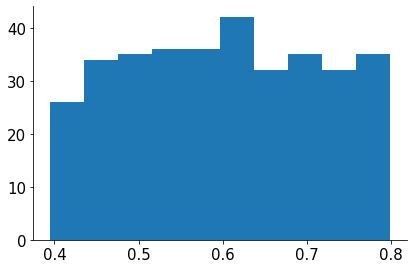

In [15]:
  counts, bins = np.histogram(dat['gocue'])
plt.hist(bins[:-1], bins, weights=counts)
print(correct_firing_rates.shape)

In [16]:
print(neurons_indices_in_area[1].shape)
print(dat['spks'].shape)


()
(1348, 343, 250)


In [150]:
y.shape, samples.shape

((1450,), (1450, 250))

TRAIN AND TEST SPLIT

In [27]:
samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.23, random_state=42)




#samples_train, AllMean, AllSTD = zscore(samples_train, window = [0,250] )

#print(AllMean[2:5],AllSTD[2:5],samples_train[3:6])

#samples_test, AllMeanBaseline, AllMeanSTD = zscore(samples_test, window = [0,250] )



In [28]:
# C: float, default=1.0, Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
clf = LogisticRegressionCV(Cs=5, cv=4, penalty='l1', solver='saga', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train) # crossvalidation
#clf = LogisticRegressionCV(Cs=5, cv=4, penalty='l1', solver='saga', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train) # crossvalidation


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [29]:
clf.score(samples_test,y_test)

0.6137724550898204

In [30]:
clf.score(samples_train,y_train)

0.6406810035842294

In [31]:
print(clf.C_) # OPtimal C value as specified with Crossvalidation

[0.01]


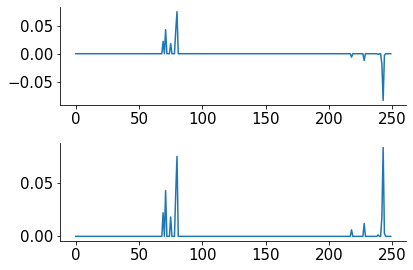

In [32]:
plt.subplot(211)
plt.plot(clf.coef_[0,:])
plt.subplot(212)
plt.plot(np.abs(clf.coef_[0,:]))
plt.show()

In [33]:
def clasificator_analisis(model, X, y):
  '''Compute accuracy with CV, confusion matrix, precision-recall scores and plot ROC and precision-recall curves.
   Args: 
     model = model object trained from sklearn
         X = input features in train or test
         y = target in train or test
   Return:
    Print of all the scores computed and save accuracy, cm, precision, recall
'''
  
  from sklearn.model_selection import cross_val_predict, cross_val_score
  from sklearn.metrics import confusion_matrix, precision_score, recall_score, plot_precision_recall_curve, plot_roc_curve

  #accu = cross_val_score(model, X, y, cv=5, scoring="accuracy").mean()
  #print(f'{model} \nAccuracy:{accu}\n')
  pred = model.predict(X)
  cm = confusion_matrix(y,pred)
  print(f'Confusion Matrix: \n {cm}\n')
  precision = precision_score(y,pred)
  print('Precision:',precision)
  recall = recall_score(y, pred)
  print('Recall:', recall)
  plot_precision_recall_curve(model, X, y)
  plt.show()

  plot_roc_curve(model, X, y)
  plt.plot([0, 1], [0, 1], color='0.5', ls=':')
  plt.show()


Confusion Matrix: 
 [[118  36]
 [ 93  87]]

Precision: 0.7073170731707317
Recall: 0.48333333333333334


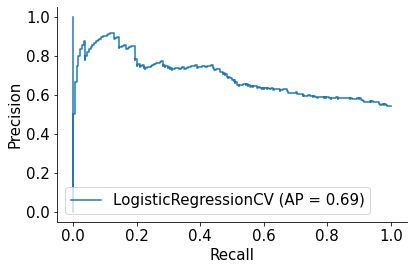

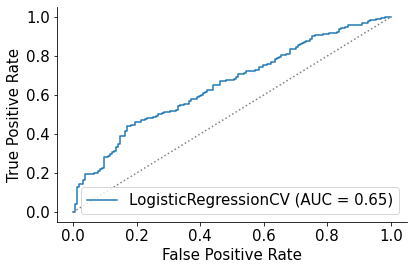

In [34]:
clasificator_analisis(clf, samples_test, y_test)

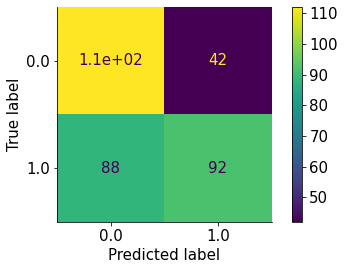

In [158]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, samples_test, y_test)
